<a href="https://colab.research.google.com/github/ScriptsRemote/SCRIPTSREMOTE/blob/main/NDVI_estatisticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Estatísticas zonais***

* Abrir coleção
* Selecionar imagens
* Calcular NDVI
* Analisar resultado

In [1]:
##instalar bibliotecas
!pip install geemap earthengine-api -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00


In [2]:
##importar as bibliotecas
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
##Autenticação
ee.Authenticate()
ee.Initialize()

In [4]:
##Definir nossa área de estudo
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [25]:
##Obtendo coordenadas
Map.user_roi.getInfo()

{'type': 'Polygon',
 'coordinates': [[[-54.18972, -30.243127],
   [-54.184313, -30.248317],
   [-54.173498, -30.245203],
   [-54.17058, -30.242385],
   [-54.157448, -30.232078],
   [-54.165173, -30.224291],
   [-54.18972, -30.243127]]]}

In [26]:
##Região de interesse
region= ee.Geometry.Polygon(Map.user_roi['coordinates'])
region

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -54.18972,
              -30.243127
            ],
            [
              -54.165173,
              -30.224291
            ],
            [
              -54.157448,
              -30.232078
            ],
            [
              -54.17058,
              -30.242385
            ],
            [
              -54.173498,
              -30.245203
            ],
            [
              -54.184313,
              -30.248317
            ],
            [
              -54.18972,
              -30.243127
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [10]:
###Definir a minha coleção de imagens
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                      .filterBounds(region)\
                      .select('B.*')\
                      .filterDate('2023-01-01','2023-04-01')\
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5))\
                      .sort('CLOUDY_PIXEL_PERCENTAGE')\
                      .first()

collection

In [11]:
##Aplicação do fator de escala
img = collection.multiply(0.0001)

In [16]:
##Visualizar a imagem
Map.addLayer(img,{'bands':['B4','B3','B2'],'min':0.01,'max':0.16},'RGB')
Map

Map(bottom=2466031.0, center=[-30.140599499916835, -53.99102210998536], controls=(WidgetControl(options=['posi…

In [17]:
##Calcular o ndvi
ndvi = img.normalizedDifference(['B8','B4']).rename('ndvi')

In [18]:
##Visualizar a imagem
Map.addLayer(ndvi,{'palette':['red','yellow','green'],'min':-1,'max':1},'NDVi')
Map

Map(bottom=1233263.0, center=[-30.1550725125795, -53.92381668090821], controls=(WidgetControl(options=['positi…

In [27]:
###Estatísticas região
stats = ndvi.reduceRegion(**{
    'reducer': ee.Reducer.mean().combine(**{
        'reducer2': ee.Reducer.stdDev(),
        'sharedInputs':True
    }).combine(**{
        'reducer2': ee.Reducer.max(),
        'sharedInputs':True
    }),
    'geometry':region,
    'scale':10,
    'maxPixels':1e13
})

print('Estatísticas', stats.getInfo())
type(stats)

Estatísticas {'ndvi_max': 0.9182269774551014, 'ndvi_mean': 0.8320615768664792, 'ndvi_stdDev': 0.09234436958870881}


ee.dictionary.Dictionary

In [28]:
###Transformar em um df
lista = ee.List(stats).getInfo()
data = list(lista.items())
df = pd.DataFrame(data, columns=['ndvi','valor'])
df

,ndvi,valor
0,ndvi_max,0.918227
1,ndvi_mean,0.832062
2,ndvi_stdDev,0.092344


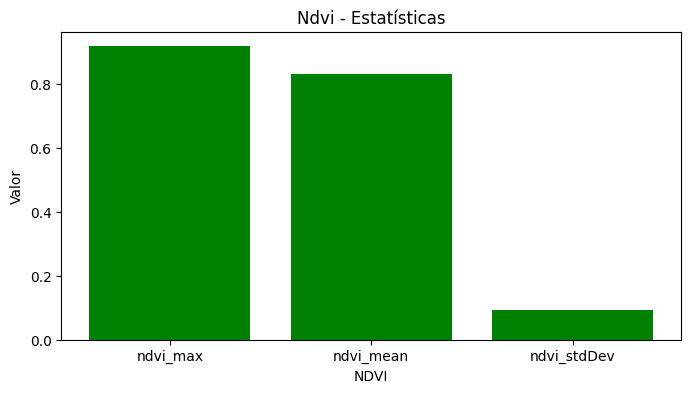

In [29]:
##criar um gráfico
plt.figure(figsize=(8,4))

plt.bar(df.ndvi, df.valor, color='green')

plt.title('Ndvi - Estatísticas')
plt.xlabel('NDVI')
plt.ylabel('Valor')

plt.savefig('Gráfico_ndvi.png')
plt.show()